# Sentiment Analysis - MOVIE Reviews


## Step 1: Exploring the data!

using tthe [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) from: 
> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.


In [1]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


positive reviews:

In [2]:
print(data['train']['pos'][2])

I watched this with my whole family as a 9 year old in 1964 on our black and white TV. I remember my father remarking that "this is how it could have happened - Adam and Eve." I vividly remember the scene when Adam finds Eve, her eyes were blackened. I asked my father why were her eyes blackened and he told because she was tired and hungry. Having not seen this episode in 45 years, I still remember it vividly - the TV transmissions back and forth with the home planet, scenes of bombs shaking the headquarters, with the final scene of the two walking off, Adam carrying his pack and Eve following. It may not have been a theatrical work of art, but it certainly left an impression on me all these years.


negative sentiment:

In [3]:
print(data['train']['neg'][2])

IT SHOULD FIRST BE SAID THAT I HAVE READ THE MANGA AND THEREFORE MY ARGUMENT IS BASED ON THE DIFFERENCES.<br /><br />This anime greatly disappointed me because it removed the comedy and high quality action of the manga and OVA. What it left behind was merely a husk of what it could have been. Many of the characters lacked the depth that is seen in the manga. Alucard is not the sympathetic character that secretly wishes for death. Walter's story lacks the betrayal. And the Nazi villains that plot to engulf the world in war are completely absent. Instead, the anime provides the Gary Stu villain Incognito who is defeated against what appear to be all odds.<br /><br />My primary complaint is not that the anime diverges from the manga, but that it does such a poor job.


In [4]:
# Installing wordcloud
!pip install wordcloud

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


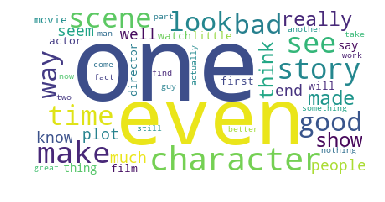

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

In [6]:
print(len(data['train']['neg']))
print(len(data['train']['pos']))
print(len(data['test']['pos']))
print(len(data['test']['neg']))

data["trainCombined"]=data['train']['neg']+data['train']['pos']
data["testCombined"]=data['test']['neg']+data['test']['pos']
print(len(data["trainCombined"]))
print(len(data["testCombined"]))

12500
12500
12500
12500
25000
25000


### Form training and test sets
After reviewing the data, I combine the positive and negative documents to get one training set and one test set.

In [7]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):

    data_train = data['train']['neg']+data['train']['pos']
    data_test = data['test']['neg']+data['test']['pos']
    
    label_train = labels['train']['neg']+labels['train']['pos']
    label_test = labels['test']['neg']+labels['test']['pos']
   
    
    data_train, data_test =shuffle(data_train,data_test, n_samples=2, random_state=69)
    labels_train, labels_test=shuffle(label_train, label_test, n_samples=2, random_state=69)

    
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 2, test = 2


## Preprocessing



### Convert each review to words

Here I am cleaning the data and removing html tags if needed.  

In [8]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def review_to_words(review):
  
    text = BeautifulSoup(review, 'html.parser').get_text()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    words = text.split(' ')
    words = [word for word in words if word not in stopwords.words('english')]
    words = [PorterStemmer().stem(w) for w in words]
    
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', '', 'test', '', 'would', 'make', 'great', 'movi', 'review', '']

Here I am creating a pickle so I can save it for later and use it again.  I am also applying the functions above to both datasets (training and test).

In [10]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
   

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
As a former 2 time Okinawan Karate world champion, I like movies about sacrifice for sport. But this movie is about so much more. This movie is so good and so deep. I have recently been plagued by very serious injury and pretty much a disastrous lack of passion. Almost lights out for me. And this silly little movie touched me so deep that like out of a daze it reminded me about what life is supposed to be about. This is a movie about living. Living your life for yourself and respect for others. Empowerment. God, bless "Bend it like Beckham" I believe it is a true gem.

--- Preprocessed words ---
['blond', 'blonder', 'pamela', 'anderson', 'denis', 'richard', 'almost', 'everi', 'scene', 'want', 'movi', 'utterli', 'unreason', 'feel', 'like', 'late', 'era', 'carri', 'seri', 'longer', 'blaze', 'trail', 'still', 'funni', 'think', 'behind', 'england', 'far', 'mark', 'pamela', 'denis', 'bubbl', 'charm', 'clearli'

## Extracting Bag-of-Words features

### Compute Bag-of-Words features
Here I implement the extract_BoW_features() function for both the training and test datasets, and store the results in features_train and features_test NumPy arrays, respectively. 

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib


def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
   
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        
    
        vectorizer = CountVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)
        features_train = vectorizer.fit_transform(words_train).toarray()

        features_test = vectorizer.fit_transform(words_test).toarray()
        

        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
    
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['rock', 'ironi', 'nazi', 'support', 'footbal', 'flip', 'lure', '1993']

--- Preprocessed words ---
['kid', '50', '60', 'anyth', 'connect', 'disney', 'definit', 'great', 'happen', 'abl', 'get', 'actor', 'actress', 'want', 'best', 'time', 'somehow', 'disney', 'manag', 'screw', 'thing', 'spite', 'abund', 'resourc', 'disney', 'afford', 'best', 'writer', 'best', 'produc', 'director', 'still', 'screw', 'thing', 'movi', 'crap', 'sad', 'thing', 'suspect', 'disney', 'arrog', 'even', 'know', 'movi', 'good', 'bad', 'due', 'talent', 'actor', 'even', 'give', '3', '10']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


Visualizing the Bag-of-Words feature vector for one of our training documents.

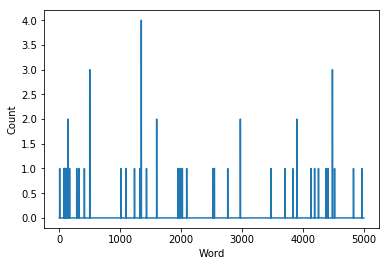

In [12]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()



### Zipf's law

"[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank."


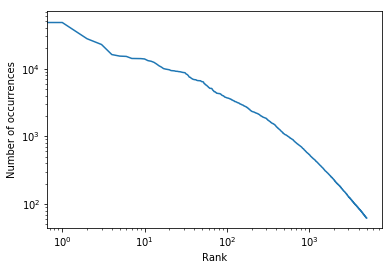

In [13]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()



### Normalize feature vectors
Normalizkng the BoW feature vectors to have unit length.  This helps with preventing large reviews dominating.


In [14]:
import sklearn.preprocessing as pr


features_train = pr.normalize(features_train, norm='l2', axis=1)
features_test = pr.normalize(features_test, norm='l2', axis=1)


## Classification using BoW features
using Naive Bayes classifier from scikit-learn (specifically, GaussianNB), and evaluate its accuracy on the test set.

In [15]:
from sklearn.naive_bayes import GaussianNB

clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# nbs_performance = BinaryClassificationPerformance(clf1.predict(features_train), labels_train, 'nbs')
# nbs_performance.compute_measures()
# print(nbs_performance.performance_measures)


# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.49596




### Gradient-Boosted Decision Tree classifier
Here I fluctuate the n_estimators to impact the test.  Still learning this model.  

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 50


def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)
    
    clf.fit(X_train,y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(features_train, labels_train),
        clf.score(features_test, labels_test)))

    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.81832, test = 0.51696


### Adverserial testing



In [17]:

my_review = "This was a great movie.  I would strongly recommend seeing because I cried it was so emotional and exceptional and amazing.  people loved it when the audienced laughed with the actor."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'


review = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary, preprocessor=lambda x: x, tokenizer=lambda x: x)
bitchFace = vectorizer.transform([review]).toarray()


sentPredict = clf2.predict(bitchFace)[0]
print(sentPredict)
print(review)

pos
['great', 'movi', '', '', 'would', 'strongli', 'recommend', 'see', 'cri', 'emot', 'except', 'amaz', '', '', 'peopl', 'love', 'audienc', 'laugh', 'actor', '']
